# Assignment One
## Introduction
The objective of this fuzzy system is to forcast electricity prices for the Queensland market. To do this, abnormalities have been removed form the data set and regression analysis has been conducted to identify trends within the data with which to build a fuzzy rule base.

## 1. Removing Outliers
Before the data could be analysed outliers in the output data must be removed, this was done via the interquartile range. As seen in fig 1. and fig 2. the absence of outliers can be seen.

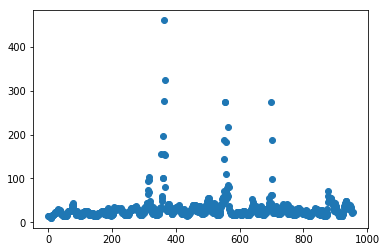

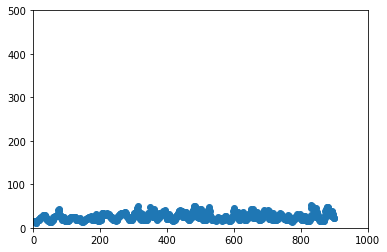

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def clean_dataset(df, file="outliers.csv"):
    price = df['P(t+1)'].values
    q1 = np.percentile(price, 25)
    q3 = np.percentile(price, 75)
    
    in_range = [q1 - 1.5 * (q3 - q1), q3 + 1.5 * (q3 - q1)]
    position = np.concatenate((np.where(price > in_range[1]),
        np.where(price < in_range[0])), axis=1)
    
    outliers = df.loc[position[0]]
    outliers.to_csv(file, index=False)
    
    df.drop(df.index[position[0]], inplace=True)
    
    return df

# Read in the .csv data to a pandas DataFrame
training_df = pd.read_csv("datasets/Training_Data.csv")
testing_df = pd.read_csv("datasets/Testing_Data.csv")

plt.plot(training_df['P(t+1)'].values, 'o')
plt.show()

training_df = clean_dataset(training_df, file="datasets/training_outlier.csv")
testing_df = clean_dataset(testing_df, file="datasets/testing_outliers.csv")

# Export the cleaned data
training_df.to_csv("datasets/cleaned_training.csv", index=False)
testing_df.to_csv("datasets/cleaned_testing.csv", index=False)

# Demonstrating the removal of outliers
plt.plot(training_df['P(t+1)'].values, 'o')
plt.xlim(0, 1000)
plt.ylim(0, 500)
plt.show()

## 2. Variable Selection
The FIS currently has six input variables, in order to reduce the complexity of the system a Correlation Coefficient Matrix (CCM) has been used to identify linear relationships between said input variables and the output variable.

In [5]:
import pandas as pd
import numpy as np

def calculate_CCM(df):
    return np.corrcoef(np.row_stack((
        df['T(t-2)'].values,
        df['T(t-1)'].values,
        df['T(t)'].values,
        df['D(t-2)'].values,
        df['D(t-1)'].values,
        df['D(t)'].values,
        df['P(t+1)'].values
    )))

training_df = pd.read_csv("datasets/cleaned_training.csv")
testing_df = pd.read_csv("datasets/cleaned_testing.csv")

training_CCM = calculate_CCM(training_df)
testing_CCM = calculate_CCM(testing_df)

print(training_CCM)

[[ 1.          0.97711422  0.94083427  0.43523077  0.49341031  0.54010843
   0.49325377]
 [ 0.97711422  1.          0.97678556  0.37103657  0.43915887  0.49715253
   0.46219849]
 [ 0.94083427  0.97678556  1.          0.29729518  0.37354107  0.44142236
   0.41799108]
 [ 0.43523077  0.37103657  0.29729518  1.          0.98603698  0.9497314
   0.52955784]
 [ 0.49341031  0.43915887  0.37354107  0.98603698  1.          0.98603361
   0.56492116]
 [ 0.54010843  0.49715253  0.44142236  0.9497314   0.98603361  1.
   0.5877078 ]
 [ 0.49325377  0.46219849  0.41799108  0.52955784  0.56492116  0.5877078
   1.        ]]


From the CCM it can now be seen that the input variables D(t) and T(t-2) are more strongly correlated with each other and the output variable P(t+1) than any other input variables, thus a subset M={T(t-2), D(t)} will be used to decrease the overall complexity of the system.

# 3. Linguistic Variable and Membership Function Selection
Now that a subset of the input data has been established these values must be fuzzified and assigned relevant membership functions. To aid in this analysis of the distribution of the input variables and the output variables was conducted to see where large 'clumpings' of data resides.

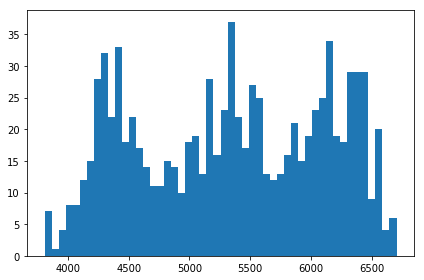

In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

training_df = pd.read_csv("datasets/cleaned_training.csv")

# Histograms to display distribution
def show_distribution(vals):   
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(vals, 50)
    fig.tight_layout()
    plt.show()

show_distribution(training_df['D(t)'].values)
#show_distribution(training_df['T(t-2)'].values)
#show_distribution(training_df['P(t+1)'].values)


Looking at the distribution of the demand, we see three peaks. Therefore we will create 5 partions of demand. For price and temperature there will be 3 partitions.

/Users/braydenkilleen/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


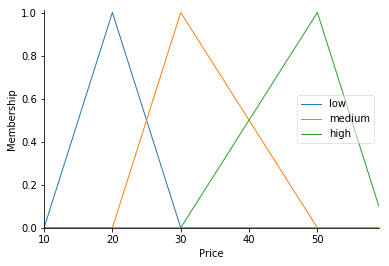

In [275]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

temp = ctrl.Antecedent(np.arange(20, 35, 1), 'Temperature')
demand = ctrl.Antecedent(np.arange(3500, 7000, 1), 'Demand')
price = ctrl.Consequent(np.arange(10, 60), 'Price')

temp['low'] = fuzz.trimf(temp.universe, [20, 20, 24])
temp['medium'] = fuzz.trimf(temp.universe, [23,26, 28])
temp['high'] = fuzz.trimf(temp.universe, [27, 30, 34])

demand['very-low'] = fuzz.trimf(demand.universe, [3500, 3500, 4250])
demand['low'] = fuzz.trimf(demand.universe, [4000, 4500, 5000])
demand['medium'] = fuzz.trimf(demand.universe, [4750, 5250, 5750])
demand['high'] = fuzz.trimf(demand.universe, [5500, 6000, 6500])
demand['very-high'] = fuzz.trimf(demand.universe, [6250, 7000, 7000])

price['low'] = fuzz.trimf(price.universe, [10, 20, 30])
price['medium'] = fuzz.trimf(price.universe, [20, 30, 50])
price['high'] = fuzz.trimf(price.universe, [30, 50, 60])
price.view()

# 4. Creating Fuzzy Rules Through Statistical Analysis
Create fuzzy rules through statistical influence along with heuristics. Firstly, view the scatter charts to see how each trends with one another.

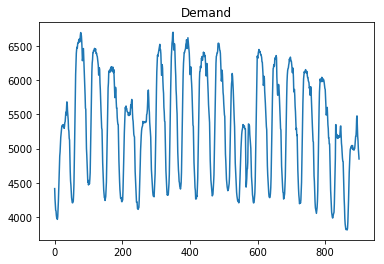

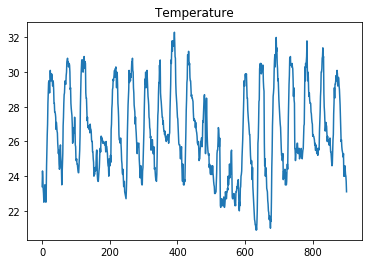

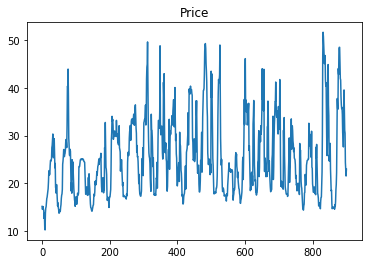

In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

training_df = pd.read_csv("datasets/cleaned_training.csv")
testing_df = pd.read_csv("datasets/cleaned_testing.csv")

plt.plot(training_df['D(t)'].values)
plt.title('Demand')
plt.show()
plt.plot(training_df['T(t-2)'].values, label="Temperature")
plt.title('Temperature')
plt.show()
plt.plot(training_df['P(t+1)'].values, label="Price")
plt.title('Price')
plt.show()


Taking our CCM from step 2 we can see that both price, temperature and demand are all positivley correlated with one another. Furthermore, assessment of the plots of each of these graphs shows that increases in temperature align with increases in demand which align with increases in pricing. Therefore, we can use these heuristics to begin building a rule base.

In [276]:
import numpy as np
r1 = ctrl.Rule(temp['low'] & demand['very-low'] | demand['low'] | demand['medium'], price['low'])
#r2 = ctrl.Rule(temp['low'] & demand['low'], price['low'])
#r3 = ctrl.Rule(temp['low'] & demand['medium'], price['low'])
r4 = ctrl.Rule(temp['low'] & demand['high'], price['medium'])
r5 = ctrl.Rule(temp['low'] & demand['very-high'], price['high'])

r6 = ctrl.Rule(temp['medium'] & demand['very-low'], price['low'])
r7 = ctrl.Rule(temp['medium'] & demand['low'], price['low'])
r8 = ctrl.Rule(temp['medium'] & demand['medium'], price['medium'])
r9 = ctrl.Rule(temp['medium'] & demand['high'], price['medium'])
r10 = ctrl.Rule(temp['medium'] & demand['very-high'], price['medium'])

r11 = ctrl.Rule(temp['high'] & demand['very-low'], price['low'])
r12 = ctrl.Rule(temp['high'] & demand['low'], price['low'])
r13 = ctrl.Rule(temp['high'] & demand['medium'], price['medium'])
r14 = ctrl.Rule(temp['high'] & demand['high'], price['high'])
r15 = ctrl.Rule(temp['high'] & demand['high'] | demand['very-high'], price['high'])




pricing_ctrl = ctrl.ControlSystem(
    [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15])

pricing = ctrl.ControlSystemSimulation(pricing_ctrl)

Temperature = training_df['T(t-2)'].values
Demand = training_df['D(t)'].values
length = len(training_df['D(t)'])
SystemOutputs = np.zeros(length)

for i in range(length):
    pricing.input['Temperature'] = Temperature[i]
    pricing.input['Demand'] = Demand[i]
    pricing.compute()
    SystemOutputs[i] = pricing.output['Price']
    
TargetOutputs = np.array(training_df['P(t+1)'].values)

RErr = np.sum(np.absolute(TargetOutputs - SystemOutputs)
              /np.absolute(TargetOutput))/length



print('The Average Relative Error Value is', RErr)

import numpy as np
import matplotlib.pyplot as plt

input = np.arange(901)
plt.plot(input, TargetOutputs)
plt.plot(input, SystemOutputs)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('')
plt.legend(['Target Outputs', 'System Outputs'])
plt.show()


AssertionError: 

In [266]:
# Calculate the degree of support for each rule
# IF x is A and y is B THEN z is C

# To calc: the sum of the all elements passing through the
# membership functions divided by N.

# A = Temperature.
# B = Demand.
# C = Price.